In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

### Load Data

In [2]:
train = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [3]:
print(f"Train data have {train.shape[0]} records")
print(f"Test data have {test.shape[0]} records")

Train data have 27455 records
Test data have 7172 records


### Dsiplay data

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


### Check for train, test dataset for na

In [6]:
train.isna().any().sum(), test.isna().any().sum()

(0, 0)

### Check for train data for labels

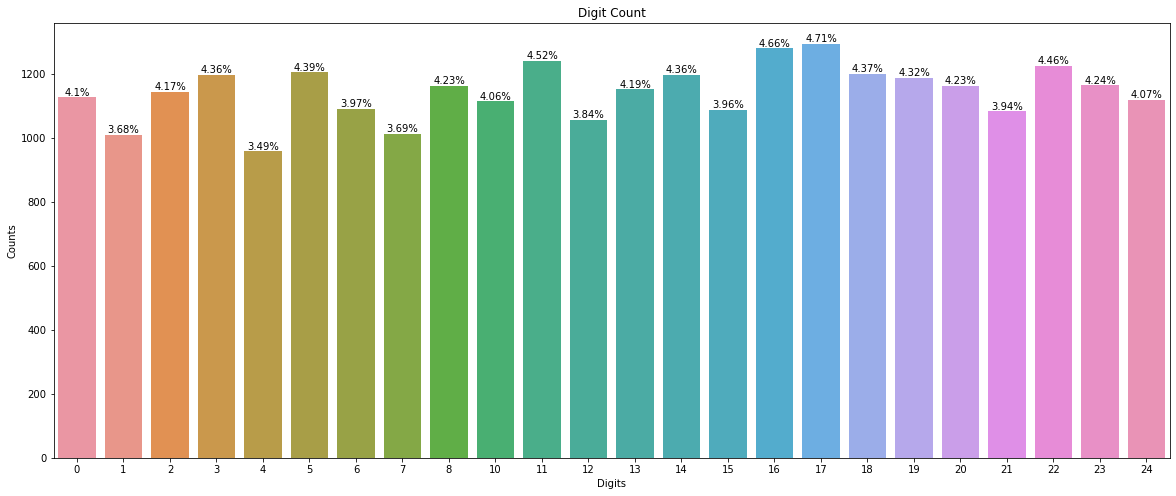

In [7]:
df_digit_counts =  train.label.value_counts().reset_index()

plt.figure(figsize=(20,8))
ax = sns.barplot(x='index', y='label', data=df_digit_counts)

for i in ax.patches:
    v1 = round((i.get_height()/len(train))*100, 2)
    ax.annotate(f'{v1}%', (i.get_x()+0.4, i.get_height()), ha='center', va='bottom',color= 'black')

plt.title("Digit Count")
plt.ylabel("Counts")
plt.xlabel("Digits")
plt.show()

### Configs

In [8]:
IMG_W = 28
IMG_H = 28
IMG_C = 1

EPOCHS = 20
BATCH_SIZE=16

CLASSES = len(train['label'].unique())
CLASSES

24

### Let see some images

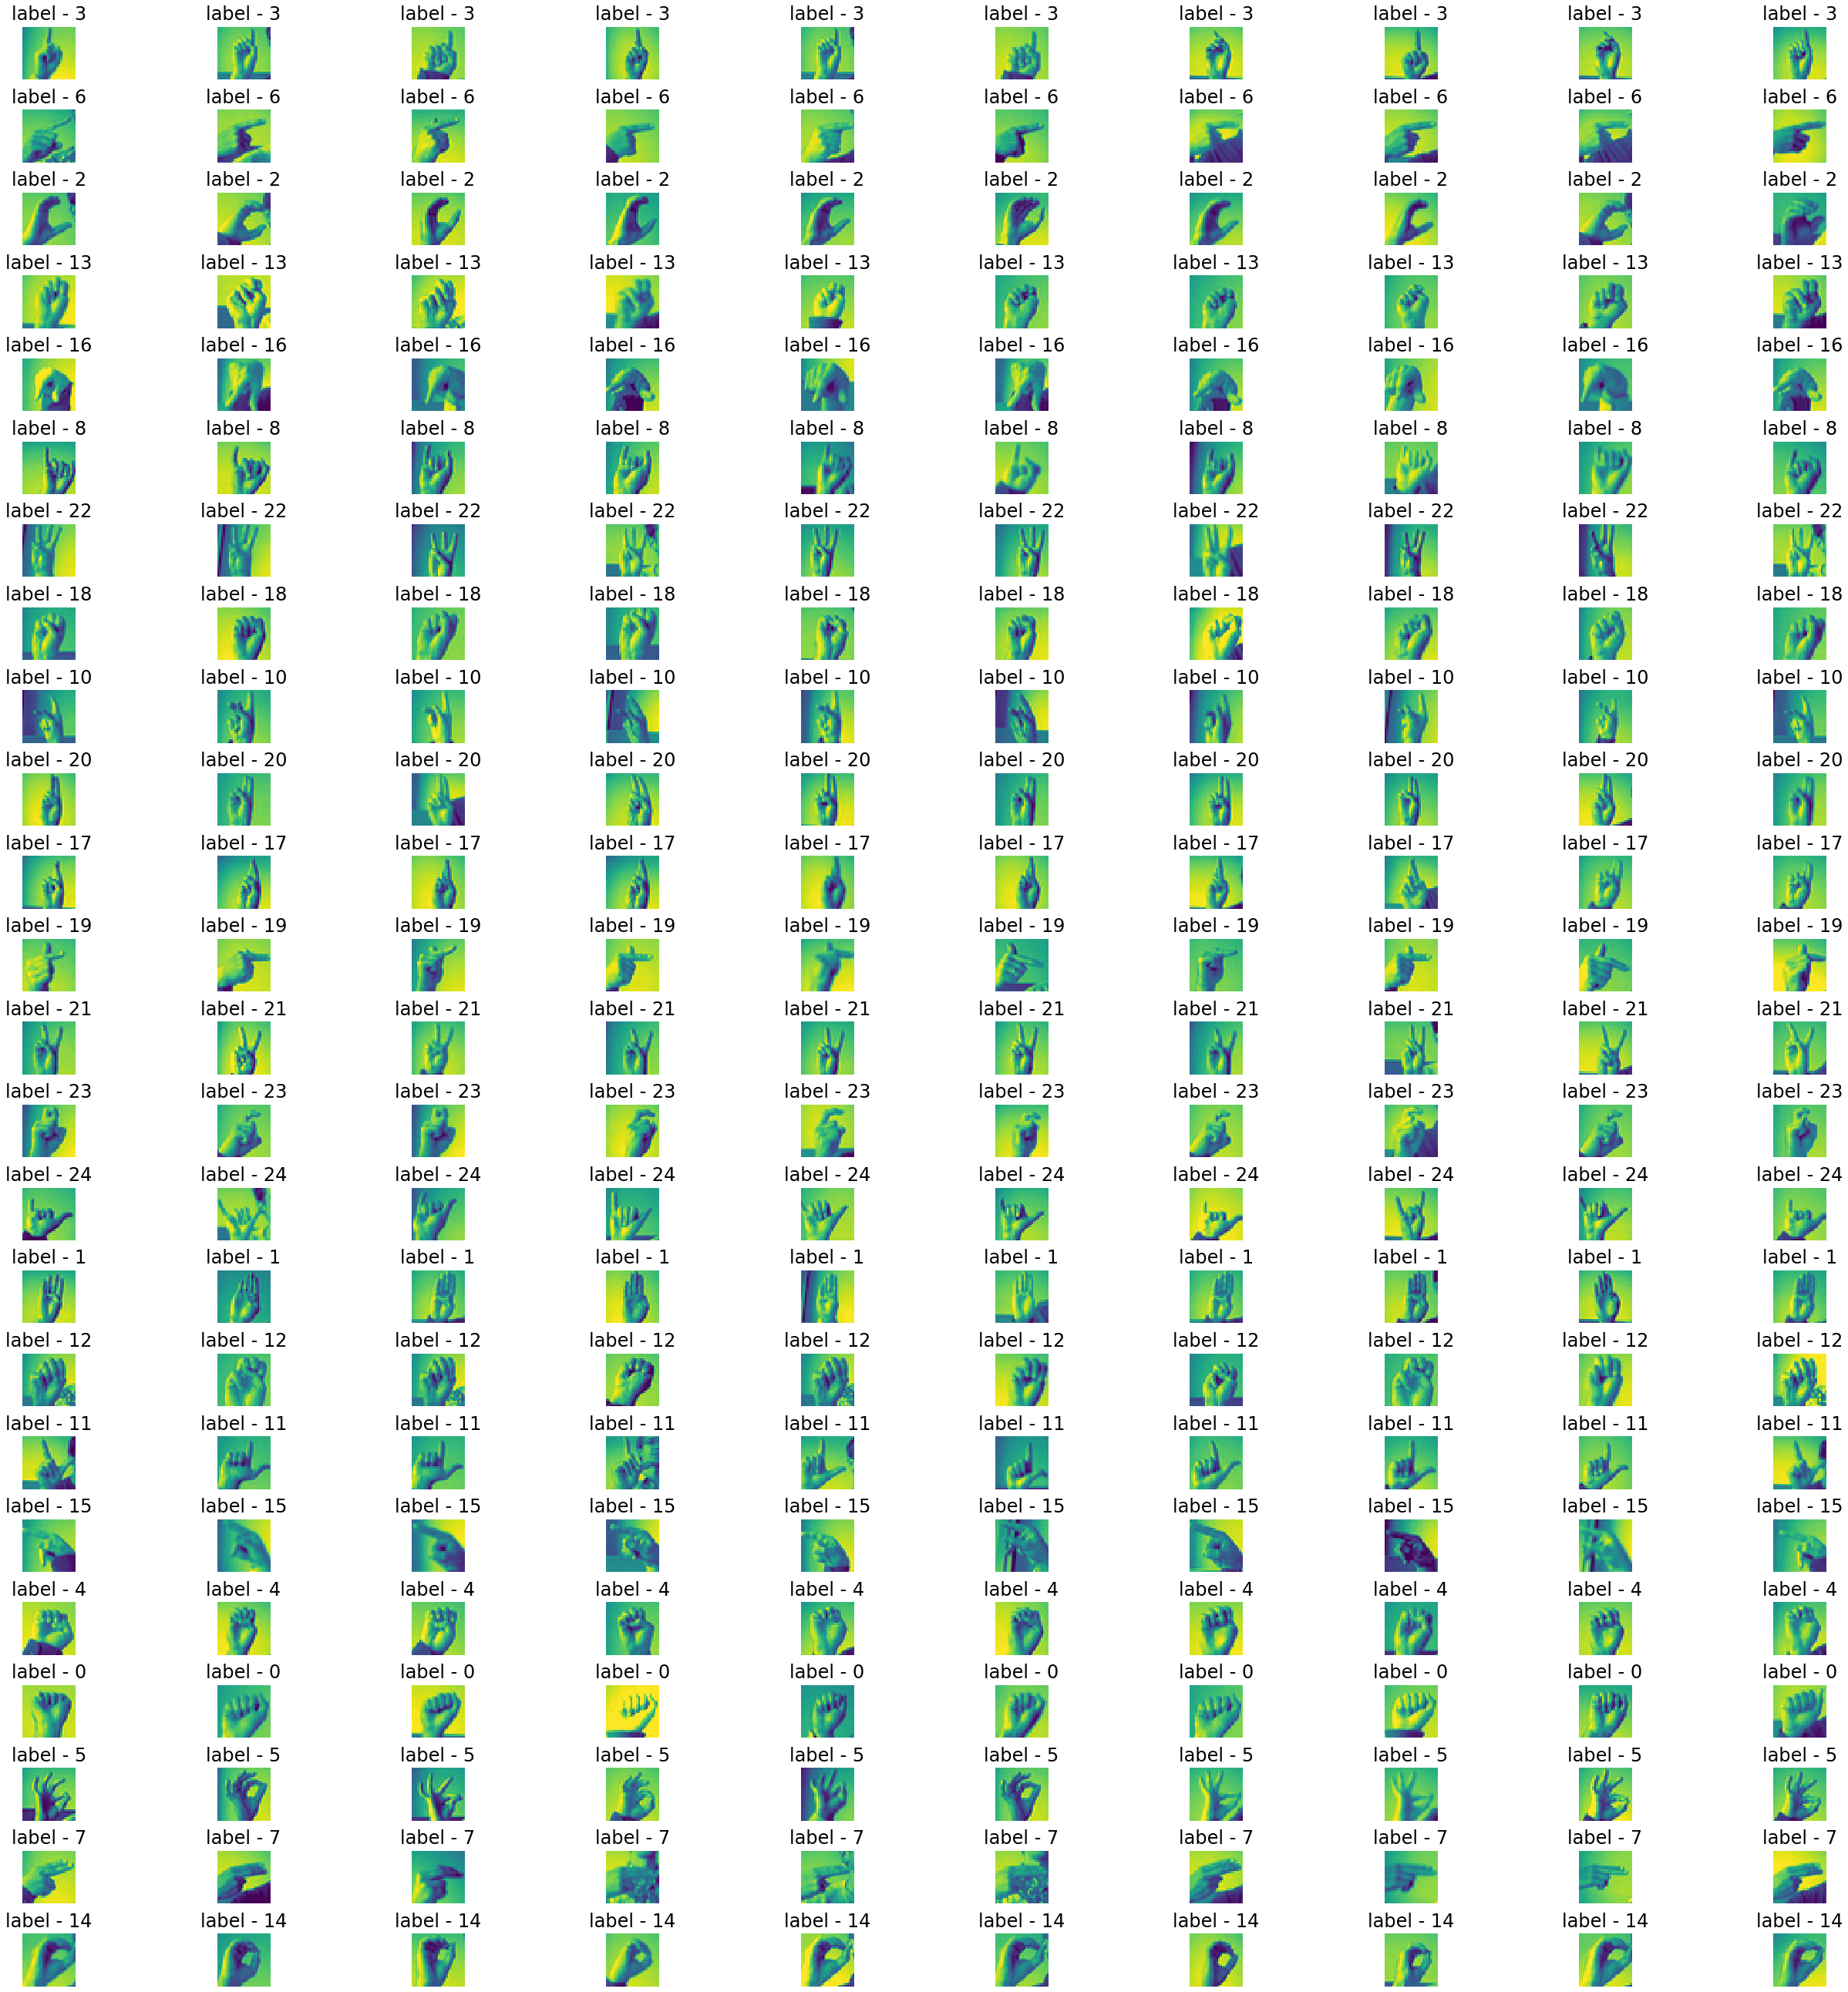

In [9]:
rows = len(train['label'].unique())
cols = 10
fig, axs = plt.subplots(rows, cols, figsize=(36, 36))
for i,lbl in enumerate(train['label'].unique()):
    imgs = np.array(train[train['label'] == lbl].iloc[0:cols,1:])
    for j,img in enumerate(imgs):
        img = img.reshape(IMG_W,IMG_H)
        axs[i,j].matshow(img)
        axs[i,j].axis('off')
        axs[i,j].set_title(f'label - {str(lbl).upper()}', fontsize=24)
fig.tight_layout()

### Create features, labels

In [10]:
train_X, train_y = train.drop(columns=['label']), train["label"]
test_X, test_y = test.drop(columns=['label']), test["label"]

### Convert to np.array

In [11]:
train_X = np.array(train_X)
train_y = np.array(train_y)

test_X = np.array(test_X)
test_y = np.array(test_y)

### Divide features by 255 to Normalize

In [12]:
train_X = train_X / 255
test_X = test_X / 255

### Reshape features 

In [13]:
train_X = train_X.reshape(-1,28,28,1)
test_X = test_X.reshape(-1,28,28,1)

### Transform labels using LabelBinarizer

In [14]:
label_binarizer = LabelBinarizer()
train_y = label_binarizer.fit_transform(train_y)
test_y = label_binarizer.fit_transform(test_y)

In [15]:
train_y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

### Create train, validation data

In [16]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42, shuffle=True)

In [17]:
def create_model():
    clear_session()
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (IMG_W,IMG_H,IMG_C)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(CLASSES, activation = "softmax"))
    
    return model

In [18]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

In [19]:
model.compile(optimizer='adamax', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

### Generate Image using ImageDataGenerator

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

### Train model

In [21]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, 
                              validation_data = (X_val,y_val), 
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                              callbacks=[lr_reduction, es], 
                              shuffle=True)

Epoch 1/20
1372/1372 [==============================] - 17s 12ms/step - loss: 2.2316 - accuracy: 0.3459 - val_loss: 0.5601 - val_accuracy: 0.7931
Epoch 2/20
1372/1372 [==============================] - 16s 11ms/step - loss: 0.7141 - accuracy: 0.7592 - val_loss: 0.0709 - val_accuracy: 0.9752
Epoch 3/20
1372/1372 [==============================] - 21s 15ms/step - loss: 0.2736 - accuracy: 0.9119 - val_loss: 0.0197 - val_accuracy: 0.9936
Epoch 4/20
1372/1372 [==============================] - 16s 12ms/step - loss: 0.1416 - accuracy: 0.9537 - val_loss: 0.0048 - val_accuracy: 0.9985
Epoch 5/20
1372/1372 [==============================] - 16s 12ms/step - loss: 0.0925 - accuracy: 0.9699 - val_loss: 0.0065 - val_accuracy: 0.9982
Epoch 6/20
1372/1372 [==============================] - 18s 13ms/step - loss: 0.0670 - accuracy: 0.9791 - val_loss: 2.1503e-04 - val_accuracy: 1.0000
Epoch 7/20
1372/1372 [==============================] - 16s 11ms/step - loss: 0.0482 - accuracy: 0.9845 - val_loss: 3.58

### Visualize performance

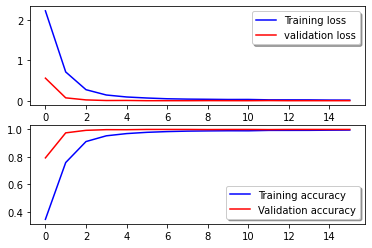

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Check performance on test data

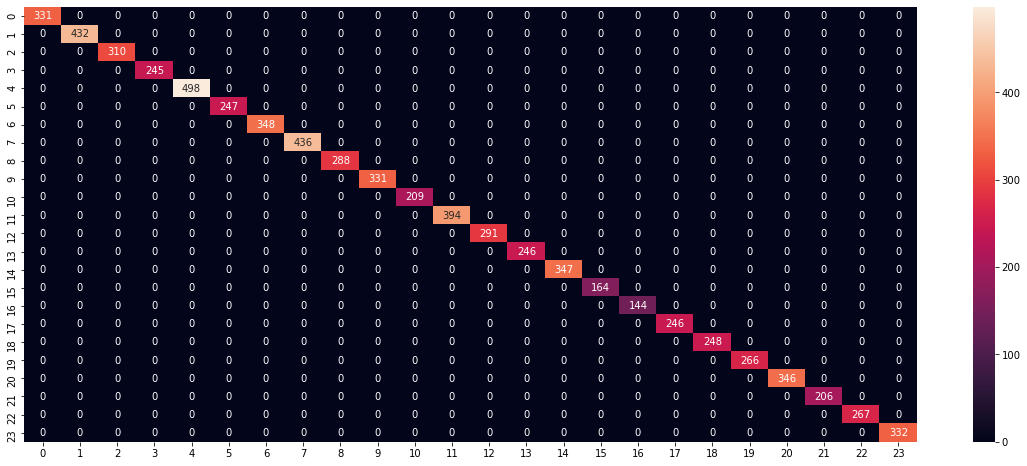




              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       1.00      1.00      1.00       394
          12       1.00      1.00      1.00       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       1.00      1.00      1.00       144
          17       1.00 

In [23]:
ypred = model.predict(test_X)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(test_y, axis=1)

cf_matrix = confusion_matrix(ytest, ypred)

plt.figure(figsize=(20,8))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

print("\n\n")
print(classification_report(ytest, ypred))

In [24]:
all_classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(ytest, ypred, target_names = all_classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    